In [1]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import jax

key = jax.random.PRNGKey(420)
key2 = jax.random.PRNGKey(69)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.1)
k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(0, None)), in_axes=(None, 0))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(0, None)), in_axes=(None, 0))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(0, None)), in_axes=(None, 0))

def rhs(x):
    return sp.special.ellipj(10*(x[0]-x[1]),0.99)[2]#jnp.sin(3*jnp.pi*jnp.sqrt(x[0]**2+x[1]**2))

#true_solution=jit(jax.vmap(true_solution_single,in_axes=0))
#rhs_func = jax.vmap(rhs)#jit(jax.vmap(laplacian(true_solution_single)))

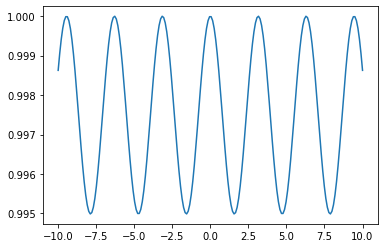

In [3]:
xgrid = jnp.linspace(-10,10,200)

plt.plot(xgrid,[sp.special.ellipj(x,0.01)[2] for x in xgrid])

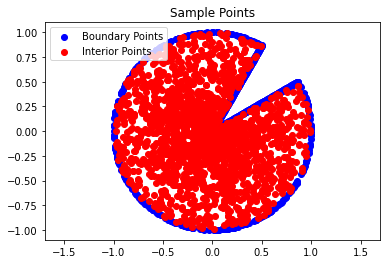

In [4]:
num_interior = 2000
num_per_boundary = 300
num_boundary=3*num_per_boundary

angle1 = jnp.pi/3; angle2 = jnp.pi*(13/6)

# Generate random interior points
thetas = jax.random.uniform(key, shape=(num_interior,1), minval=angle1, maxval=angle2)
rs = jax.random.uniform(key2, shape=(num_interior,1))

x_interior = rs * jnp.cos(thetas)
y_interior = rs * jnp.sin(thetas)

interior_points = jnp.column_stack((x_interior, y_interior))

# Generate points on the boundary
ts = jax.random.uniform(key, shape=(num_per_boundary,1),minval=angle1, maxval=angle2)
x_boundary = jnp.cos(ts)
y_boundary = jnp.sin(ts)
boundary_points1 = jnp.column_stack((x_boundary, y_boundary))

boundary_point_samples=np.linspace(0,1,num_per_boundary)
x_boundary = boundary_point_samples*jnp.cos(angle1)
y_boundary = boundary_point_samples*jnp.sin(angle1)
boundary_points2 = jnp.column_stack((x_boundary, y_boundary))

boundary_point_samples=np.linspace(0,1,num_per_boundary)
x_boundary = boundary_point_samples*jnp.cos(angle2)
y_boundary = boundary_point_samples*jnp.sin(angle2)
boundary_points3 = jnp.column_stack((x_boundary, y_boundary))

boundary_points = np.vstack([
    boundary_points1,
    boundary_points2,
    boundary_points3,
])

all_points = jnp.vstack([interior_points, boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='blue', label='Boundary Points')
plt.scatter(interior_points[:, 0], interior_points[:, 1], c='red', label='Interior Points')
plt.legend()
plt.axis('equal')
plt.show()

In [5]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(boundary_points,interior_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

#interior_rhs = rhs_func(interior_points)


In [6]:
interior_rhs = []
for i in range(num_interior):
    interior_rhs.append(rhs(interior_points[i]))
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

In [7]:
max(interior_rhs)-min(interior_rhs)

0.8999986044680718

In [8]:
nugget=1e-10
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))
coef_sol=jax.scipy.linalg.solve(Kmat,rhs_total,assume_a='pos')

eval_K=vec_k(interior_points,all_points).T
sol_vals = eval_K@coef_sol

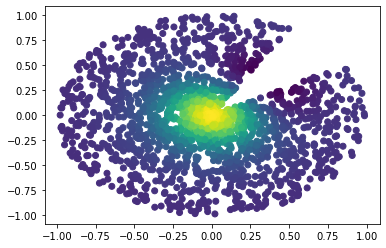

In [9]:
plt.scatter(interior_points[:,0],interior_points[:,1],c=sol_vals)